# Corticospinal lesion analysis and longitudinal analysis of lesion volume and motor function

This notebook is divided into two parts. First the corticospinal lesion volumes are computed and their relationship with motor assessments is investigated. Subsequently, the correlation between the change in lesion volume and clinical scores over time is explored. 


# Corticospinal lesion analysis

In [27]:
# Import of necessary libraries
import scipy.ndimage as ndi
import numpy as np
import nibabel as nib
import os
from scipy.ndimage import label, binary_dilation
import random
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D  # For custom legend handles

## Necessary functions

Functions were created for generating binary masks of the corticospinal tracts and for processing the data and investigating the relationship between the lesion information and clinical outcomes. The funtions for data filtering and correlation computation are same as used in the other correlation scripts.

The corticospinal masks were generated by using tract atlases from FMRIB's XTRACT which are converted to subject space. These are atlases of different pyramidal tracts with unique labels. These labels can thereby be used to extract the tracts of interest.

In [3]:
def get_parcellation(first,last):

    """
    Generates and saves binary corticospinal tract masks for a subset of patient files

    Args:
        first (int): The index of the first file of patient files to process
        last (int): The index of the last file of patient files to process
    
    Returns:
        None: Saves the generated binary mask as a NIfTI file
    """

    # Path to the folder of atlases containing different brain tracts in subject space
    tract_atlas = "/corticospinal_tract/tract_atlases_subjectspace/"

    # Output path where the masks will be saved
    output_path = "/corticospinal_tract/corticospinal_tracts/"

    # Path to the MRI images of the patients
    path_subjects = "/input_inference/"

    # The subsection of patients for whom corticospinal masks are to be generated
    patient_visits = sorted(os.listdir(path_subjects))[first:last]

    for subject in patient_visits:

        # Loading the tracts atlas for the patient
        tract_path = os.path.join(tract_atlas, f"{subject}_tracts.nii.gz")
        all_tracts = nib.load(tract_path).get_fdata()

        # Using the label to extract the corticospinal tracts from the tracts atlas
        mask_L = all_tracts == 14
        mask_R = all_tracts == 15

        # Create a binary mask of the corticospinal tracts
        parcellations = np.zeros_like(mask_L, dtype=np.uint8)

        parcellations[mask_L] = 1  
        parcellations[mask_R] = 1  

        # Save the mask in the output path
        parcellation_mask = nib.Nifti1Image(parcellations, nib.load(tract_path).affine, nib.load(tract_path).header)
        output = os.path.join(output_path, f"{subject}_parcellation")
        nib.save(parcellation_mask, output)

    print(f"{first} to {last} done!")
        

In [ ]:
def filter_data(df, columns):
 
    """
    Filters a DataFrame to include only the specified columns and removes rows that do not correspond to predefined MRI scan timepoints

    Args:
        df (pd.DataFrame): The input dataset
        columns (list): List of column names to retain

    Returns:
        pd.DataFrame: The filtered dataset
    """

    # Create a dataset of only the relevant columns
    filtered_df = df[columns].copy()

    # The event names corresponding to the timepoints of the MRI scans
    events = ["V1", "V3", "V4", "V6"]
    
    for index, row in filtered_df.iterrows():

        # Remove rows from events where no MRI scan was conducted
        if row['Event name'] not in events:
            filtered_df = filtered_df.drop(index)

    # Convert patient ID to integers
    filtered_df.loc[:, "Subject sequence number"] = filtered_df.loc[:, "Subject sequence number"].astype(int)

    return filtered_df

In [13]:
def plot_metrics(merged_df, column_name, metrics_columns, corr="Spearman"):
    
    """
    Generates a grid of scatter plots showing the relationship between a given clinical variable and multiple metric columns,
    with displayed correlation coefficients

    Args:
        merged_df (pd.DataFrame): Merged dataset containing both clinical and metric data
        column_name (str): The clinical score column to correlate with each metric
        metrics_columns (list): List of metric column names to include in the plots
        corr (str, optional): Type of correlation to compute ('Spearman' or 'Pearson'). Defaults to 'Spearman'

    Returns:
        None: Displays a matplotlib figure
    """

    # Create a 3x6 grid of subplots
    fig, axes = plt.subplots(1,2, figsize=(10,5))  

    # Define colors for different event timepoints
    colors = {"V1": "darkblue", "V3": "green", "V4": "orange", "V6": "magenta"}

    # Flatten the axes array for easy indexing
    axes = axes.flatten() 

    for i, metric in enumerate(metrics_columns):
        x = merged_df[column_name].astype(float)
        y = merged_df[metric].astype(float)

        # Plot scatterplot
        axes[i].scatter(x, y, marker=".", c=merged_df["Event name"].map(colors))

        # Compute correlation and display in plot title
        if corr == "Pearson":
            r, p = pearsonr(x, y)
        else:
            r, p = spearmanr(x, y)

        axes[i].set_title(f"r = {round(r, 3)}, p = {round(p, 3)}")
        axes[i].set_ylabel(metric)

    # Set main title
    if "hand" in column_name or "walk" in column_name:
        fig.suptitle(f"{column_name} [s] - {corr} correlation", fontsize=20, fontweight="bold")
    else:
        fig.suptitle(f"{column_name} - {corr} correlation", fontsize=20, fontweight="bold")

    # Adjust layout
    fig.tight_layout()

    # Add legend for event timepoints
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markersize=10,
               markerfacecolor=color, label=label)
        for label, color in colors.items()
    ]
    fig.legend(handles=legend_handles, title="Event Name", loc="upper right", bbox_to_anchor=(1.05, 1))

    plt.show()


## Load data

Only the relationship between the 9-hole peg test (9-HPT) scores and the lesion volumes were of interest. Therefore, the 9-HPT was extracted from the clincal data. 

A dataset was generated, containing information about the volume of the T1, T2 and corticospinal lesions for all subjects. This data was thereafter merged with the clinical data.

In [2]:
# Load the 9-HPT data
HPT_df = pd.read_excel('/Data/clinical_data/HPT-data.xlsx', sheet_name="HPT")
HPT_columns = ["Subject sequence number", "Event name","Dominant hand trial 2 time", "Non-dominant hand trial 2 time"]


In [5]:
# Path to the T2 lesion masks, corticospinal tract masks and T1 lesion masks
all_lesions_path = "/Inference/input_inference/"
tracts_path = "/corticospinal_tract/corticospinal_tracts/"
T1_lesions_path = "/T1_lesions/"

In [29]:
# sorted list of T2 lesion folders
subjects = sorted(os.listdir(all_lesions_path))

lesion_df = pd.DataFrame()
visits_mapping = {"visit_1":"V1", "visit_2":"V3", "visit_3":"V4", "visit_4":"V6"}

# Initialize lists of patient and lesion information
IDs = []
visits = []
lesion_volumes = []
spinal_lesions = []
T1_lesion_volumes = []

for subject in subjects:

    # Load the T1 and T2 masks and the corticospinal masks
    full_lesion_path = os.path.join(all_lesions_path, subject, f"MS_{subject.split('_')[0]}.nii.gz")
    tracts = os.path.join(tracts_path, f"{subject}_parcellation.nii")
    T1_lesions = os.path.join(T1_lesions_path, f"{subject}.nii.gz")

    lesion_mask = nib.load(full_lesion_path).get_fdata()
    tract_mask = nib.load(tracts).get_fdata()
    T1_lesion_mask = nib.load(T1_lesions).get_fdata()

    # Extract patient ID and time point
    IDs.append(int(subject[3:6]))
    visits.append(visits_mapping[subject[7:]])

    # Compute the T1 lesion and T2 lesion volume
    lesion_volumes.append(np.sum(lesion_mask))
    T1_lesion_volumes.append(np.sum(T1_lesion_mask))

    # Compute spinal lesion volume by counting overlapping voxels between T2 lesion mask and corticospinal mask
    overlap = lesion_mask*tract_mask
    spinal_lesions.append(np.sum(overlap))

# Create DataFrame of lesion information
lesion_df["Subject sequence number"] = IDs
lesion_df["Event name"] = visits
lesion_df["Lesion volume"] = lesion_volumes
lesion_df["Spinal lesion volume"] = spinal_lesions
lesion_df["T1 lesion volume"] = T1_lesion_volumes


In [31]:
# Add 9-HPT scores to the lesion dataset
HPT_filtered = filter_data(HPT_df, HPT_columns)
merged = pd.merge(HPT_filtered, df, on=["Subject sequence number", "Event name"], how="inner").dropna()

## Correlation analysis

The relationship between the corticospinal lesions and the 9-HPT outcomes were investigated through scatterplot and Spearman correlation coefficient.

The plots showed that there is a weak trend, but the correlation value is low due to several patients having spinal lesions of near zero. Therefore the smallest lesions were removed and the correlation was recalculated, revealing a stronger relationship.

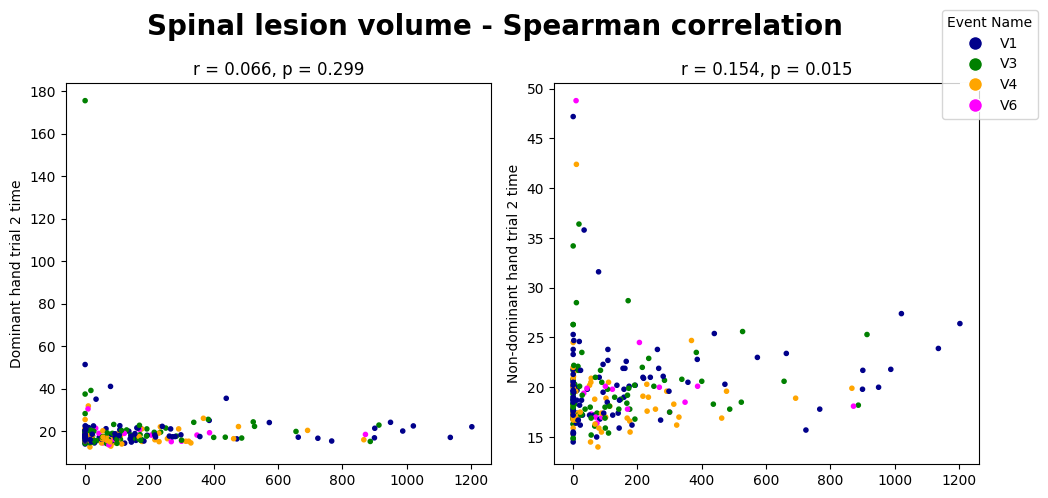

In [15]:
# Plot scatterplot and compute correlation between spinal lesions and 9-HPT scores
plot_metrics(merged, 'Spinal lesion volume', HPT_columns[2:], corr="Spearman")

In [32]:
# Filter away all corticospinal lesions that are less than 50 voxels
merged_filtered = merged[merged['Spinal lesion volume'] > 50]

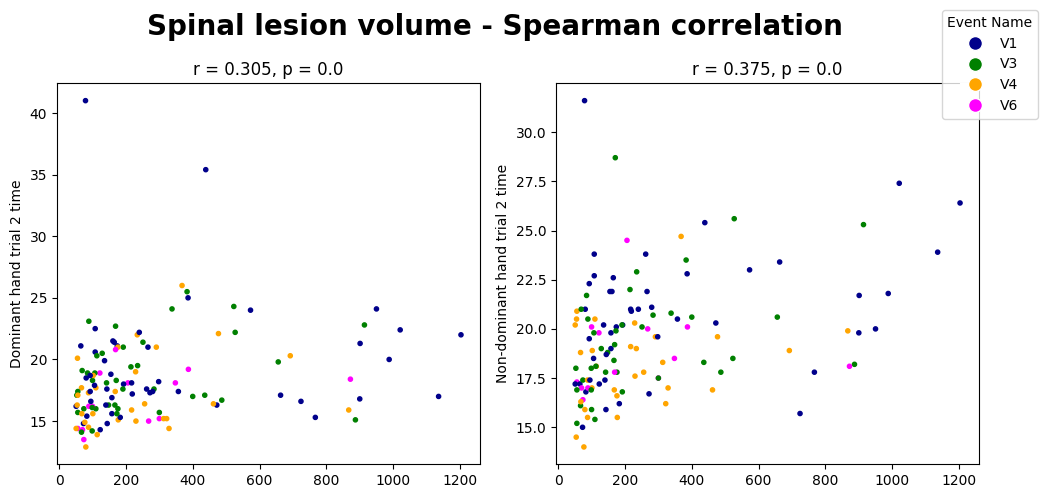

In [17]:
# Plot scatterplot and compute correlation between spinal lesions and 9-HPT scores with the smallest volumes removed
plot_metrics(merged_filtered, 'Spinal lesion volume', HPT_columns[2:], corr="Spearman")

# Longitudinal analysis of lesion volume and motor function

The dataset containing lesion volume and clinical information was used to generate two datasets according to the first and last scan time points. Bu merging these to datasets, information about the first and last visit was acquired. The correlation between the change in lesion volume and the change in 9-HPT time score could be calculated to observe whether increased lesion volume correlates with increased time score.

In [21]:
# Generate datasets for the first and fourth timepoint
first_visit = merged.loc[merged["Event name"]=="V1"]
last_visit = merged.loc[merged["Event name"]=="V6"]

In [22]:
# Merge together the datasets of the different timepoints
time_split = pd.merge(first_visit, last_visit, on=["Subject sequence number"], how="inner")

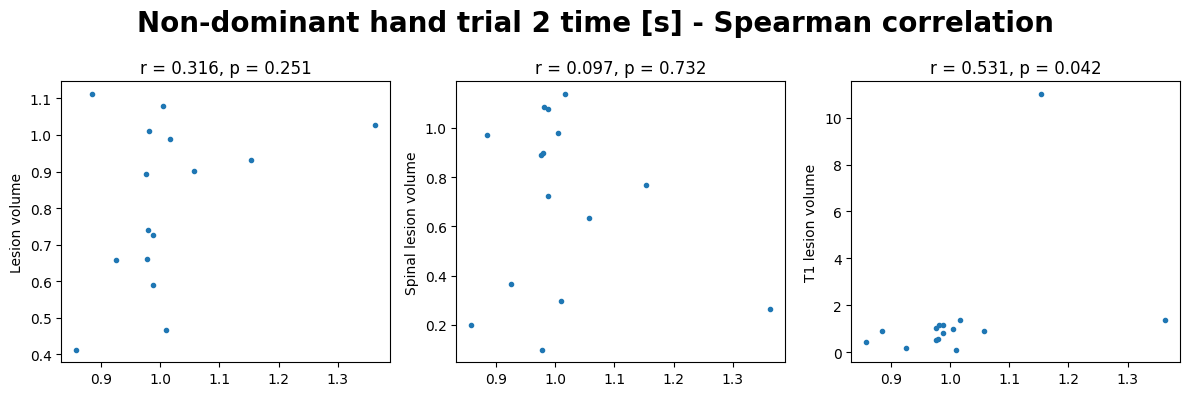

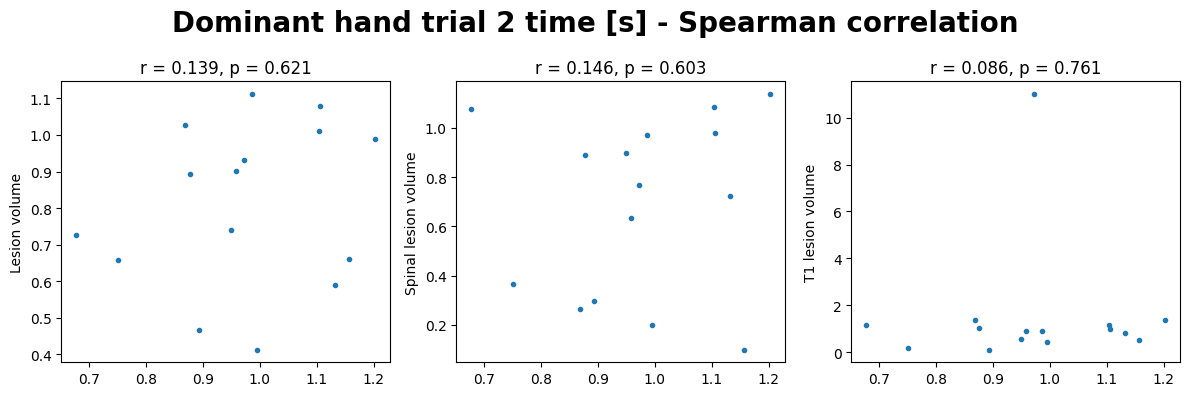

In [33]:
hpt = ['Non-dominant hand trial 2 time', 'Dominant hand trial 2 time']
les = ['Lesion volume', 'Spinal lesion volume', 'T1 lesion volume']

# Plot scatterplots and calculate correlation between longitudinal change of lesion volume and 9-hpt outcomes
for test in hpt:
    fig, axes = plt.subplots(1,3, figsize=(12,4))  

    # Flatten axes array if multiple subplots
    axes = axes.flatten() 

    for i, val in enumerate(les):
        axes[i].scatter((time_split[f'{test}_y'].astype(float)/(time_split[f'{test}_x'].astype(float)+1e-15)), (time_split[f'{val}_y']/(time_split[f'{val}_x']+1e-15)), marker = ".")

        r, p = spearmanr((time_split[f'{test}_y'].astype(float)/(time_split[f'{test}_x'].astype(float)+1e-15)), (time_split[f'{val}_y']/(time_split[f'{val}_x']+1e-15))) 
        fig.suptitle(f"{test} [s] - Spearman correlation", fontsize = 20, fontweight = "bold")

        axes[i].set_title(f"r = {round(r, 3)}, p = {round(p, 3)}")
        axes[i].set_ylabel(val)

        

    fig.tight_layout()

    plt.show()